In [11]:
import pandas as pd
import torch
from torch_geometric.nn import SAGEConv
from torch.nn import BCEWithLogitsLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

In [12]:
df = pd.read_csv('../dataset/models_data.csv')

In [13]:
len(df)

349402

In [14]:
df.head()

,parent_asin,user_id,average_rating,rating_number,price,number_categories,exists,user_deg,product_deg,user_pagerank,...,main_category_home audio & theater,main_category_industrial & scientific,main_category_musical instruments,main_category_office products,main_category_portable audio & accessories,main_category_software,main_category_sports & outdoors,main_category_tools & home improvement,main_category_toys & games,main_category_video games
0,B095LLDH4H,AFSKPY37N3C43SOI5IEXEK5JSIYA,4.6,5564.0,17.97,3,1,0.000288,0.002134,0.000021,...,False,False,False,False,False,False,False,False,False,False
1,B0787GLJNQ,AFSKPY37N3C43SOI5IEXEK5JSIYA,4.4,18317.0,11.99,5,1,0.000288,0.004037,0.000021,...,False,False,False,False,False,False,False,False,False,False
2,B075QC3TZY,AFSKPY37N3C43SOI5IEXEK5JSIYA,3.1,1833.0,12.46,3,1,0.000288,0.002711,0.000021,...,False,False,False,False,False,False,False,False,False,False
3,B00GXXJF72,AFSKPY37N3C43SOI5IEXEK5JSIYA,4.1,1630.0,119.99,5,1,0.000288,0.004210,0.000021,...,False,False,False,False,False,False,False,False,False,False
4,B003VAGXZC,AFSKPY37N3C43SOI5IEXEK5JSIYA,4.5,12006.0,29.99,5,1,0.000288,0.008940,0.000021,...,False,False,False,False,False,False,False,False,False,False


In [15]:
df['user_idx'] = df['user_id'].astype('category').cat.codes
df['prod_idx'] = df['parent_asin'].astype('category').cat.codes

n_users = df['user_idx'].max() + 1
n_prods = df['prod_idx'].max() + 1
df['prod_idx_shifted'] = df['prod_idx'] + n_users

edge_index = torch.tensor([
    df['user_idx'].values,
    df['prod_idx_shifted'].values
], dtype=torch.long)
edge_label = torch.tensor(df['exists'].values, dtype=torch.float32)

In [16]:
num_nodes = n_users + n_prods
embedding_dim = 128
x = torch.nn.Embedding(num_nodes, embedding_dim)

train_edges, test_edges, y_train, y_test = train_test_split(
    edge_index.t(), edge_label, test_size=0.2, stratify=edge_label, random_state=42
)
train_edges = train_edges.t().contiguous()
test_edges = test_edges.t().contiguous()

In [17]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout = torch.nn.Dropout(0.3)
        self.lin1 = torch.nn.Linear(hidden_channels * 2, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm2 = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm3 = torch.nn.BatchNorm1d(hidden_channels)
    
    def encode(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.batch_norm1(h)
        h = h.relu()
        h = self.dropout(h)
        
        h = self.conv2(h, edge_index)
        h = self.batch_norm2(h)
        h = h.relu()
        h = self.dropout(h)
        
        h = self.conv3(h, edge_index)
        h = self.batch_norm3(h)
        h = h.relu()
        return h
    
    def decode(self, h, edges):
        src = h[edges[0]]
        dst = h[edges[1]]
        concat = torch.cat([src, dst], dim=-1)
        h = self.lin1(concat).relu()
        h = self.dropout(h)
        return self.lin2(h).squeeze()

In [18]:
model = LinkPredictor(in_channels=embedding_dim, hidden_channels=128)
optimizer = torch.optim.AdamW(
    list(model.parameters()) + list(x.parameters()),
    lr=5e-4, weight_decay=1e-5
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [19]:
pos_weight_val = (y_train == 0).sum().float() / (y_train == 1).sum().float()
pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32)
criterion = BCEWithLogitsLoss(pos_weight=pos_weight)

best_f1 = 0
patience_counter = 0
max_patience = 15
best_model_state = None

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    h = model.encode(x.weight, train_edges)
    logits = model.decode(h, train_edges)
    loss = criterion(logits, y_train)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(list(model.parameters()) + list(x.parameters()), max_norm=1.0)
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        h_val = model.encode(x.weight, train_edges)
        logits_test = model.decode(h_val, test_edges)
        preds = (logits_test.sigmoid() > 0.5).long()
        f1 = f1_score(y_test.numpy(), preds.numpy())
        
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            best_model_state = {
                'model': model.state_dict(),
                'embedding': x.state_dict()
            }
        else:
            patience_counter += 1
        
        if patience_counter >= max_patience:
            break
    
    scheduler.step(loss.item())

if best_model_state is not None:
    model.load_state_dict(best_model_state['model'])
    x.load_state_dict(best_model_state['embedding'])

model.eval()
with torch.no_grad():
    h = model.encode(x.weight, train_edges)
    logits_test = model.decode(h, test_edges)
    probs = logits_test.sigmoid()
    preds = (probs > 0.5).long()

C:\Users\vzoppo\AppData\Local\Temp\1\ipykernel_14276\1686122791.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32)


F1-score: 0.6529
Accuracy: 0.5532
Precision: 0.5338
Recall: 0.8407


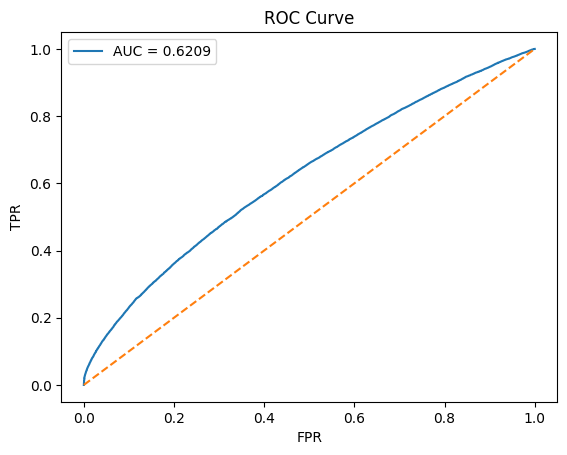

AUC: 0.6209220917943826


In [20]:
f1 = f1_score(y_test.numpy(), preds.numpy())
accuracy = accuracy_score(y_test.numpy(), preds.numpy())
precision = precision_score(y_test.numpy(), preds.numpy())
recall = recall_score(y_test.numpy(), preds.numpy())

print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

model.eval()
with torch.no_grad():
    h = model.encode(x.weight, train_edges)
    logits_test = model.decode(h, test_edges)
    probs = logits_test.sigmoid().cpu().numpy()
    y_true = y_test.cpu().numpy()

fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("AUC:", roc_auc)